In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from IPython.display import display
from collections import Counter
from collections import defaultdict

import scipy
from scipy import signal,stats
from scipy.fft import rfft,rfftfreq
from scipy import stats

import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE


# Scan Through Files and Load Data

In [2]:
# Define the base directory for the dataset
base_dir = "/Users/hhafizi/Documents/AWEAR/Data Files/ML Project Data/"

# Participant mapping (ID to Name)
participants = {
    "1": "Ale", "2": "Jenny", "3": "Antonio", "5": "Ana", "6": "Luisa"
}

# Experimental conditions
conditions = ["HVHA", "HVLA", "LVHA", "LVLA"]

# Sampling frequency
fs = 200  

def load_eeg_data(file_path, fs, num_channels=4):
    """
    Loads EEG data from a .txt file, extracting the last 60 seconds.

    Parameters:
        file_path (str): Path to the EEG .txt file.
        fs (int): Sampling frequency (Hz).
        num_channels (int): Number of EEG channels to load.

    Returns:
        np.ndarray: EEG data array of shape (num_channels, num_samples).
    """
    # Read EEG data, skipping metadata rows
    data_file = pd.read_csv(file_path, delimiter=',', skiprows=4)

    # Extract EEG data 
    eeg_data = np.array([data_file.iloc[:, i].values for i in range(1, 1 + num_channels)])

    # Extract last 60 seconds of data
    total_samples = eeg_data.shape[1]
    last_60s_samples = min(total_samples, fs * 60)  # Ensure we don't exceed available data
    eeg_data = eeg_data[:, -last_60s_samples:]  # Keep only the last 60 seconds

    return eeg_data

def scan_and_load_all_data(base_dir, fs):
    """
    Scans directories, loads EEG data for all participants and conditions.

    Parameters:
        base_dir (str): Root directory containing EEG data.
        fs (int): Sampling frequency.

    Returns:
        list: List of tuples (participant, condition, eeg_data).
    """
    all_data = []
    file_counts = defaultdict(int)  # Track the number of files per participant-condition

    for pid, pname in participants.items():
        for condition in conditions:
            folder_path = os.path.join(base_dir, f"Subject {pid} {pname}", condition)
            if not os.path.exists(folder_path):
                continue  # Skip missing directories

            for file_name in os.listdir(folder_path):
                if file_name.endswith(".txt"):
                    file_path = os.path.join(folder_path, file_name)

                    # Load EEG data
                    eeg_data = load_eeg_data(file_path, fs)

                    # Store the data
                    all_data.append((pname, condition, eeg_data))

                    # Update file count tracking
                    file_counts[(pname, condition)] += 1

    # Convert file counts to a DataFrame for a structured summary
    df_counts = pd.DataFrame(list(file_counts.items()), columns=['Participant_Condition', 'File_Count'])
    df_counts[['Participant', 'Condition']] = df_counts['Participant_Condition'].apply(pd.Series)
    df_counts.drop(columns=['Participant_Condition'], inplace=True)

    # Pivot table for clarity
    df_counts_pivot = df_counts.pivot(index='Participant', columns='Condition', values='File_Count').fillna(0)

    # Display final counts per participant-condition
    print("Final EEG File Counts per Participant-Condition:")
    display(df_counts_pivot)

    return all_data

# Load the EEG data
all_eeg_data = scan_and_load_all_data(base_dir, fs)

# Summary check
print(f"Total EEG files loaded: {len(all_eeg_data)}")
print("Example structure:", all_eeg_data[0])

Final EEG File Counts per Participant-Condition:


Condition,HVHA,HVLA,LVHA,LVLA
Participant,,,,
Ale,4,4,4,4
Ana,4,4,4,4
Antonio,4,4,4,4
Jenny,4,4,4,4
Luisa,4,4,4,4


Total EEG files loaded: 80
Example structure: ('Ale', 'HVHA', array([[ 19.06974987,  23.08640243,  24.49634471, ...,  24.24016156,
         28.00250092,  21.77930739],
       [256.98535551, 264.65963021, 254.70401653, ..., 178.18566344,
        174.73373578, 158.65216597],
       [247.96284686, 251.57933012, 225.88995732, ..., 187.74671768,
        184.99041141, 161.87782968],
       [-12.58476335,  -6.78791842, -52.44461708, ...,  14.93903037,
          3.39769911, -14.19853018]]))


# Apply Filtering

In [ ]:
# Extract all channels into a DataFrame
def create_eeg_dataframe(all_eeg_data):
    """
    Converts EEG data into a DataFrame with all channels stored for flexibility.

    Parameters:
        all_eeg_data (list): List of tuples (participant, condition, eeg_data).

    Returns:
        pd.DataFrame: DataFrame containing EEG data with columns:
                      ['Participant', 'Condition', 'Channel', 'Time', 'Voltage']
    """
    data_records = []
    
    for participant, condition, eeg_data in all_eeg_data:
        num_channels, num_samples = eeg_data.shape
        time_vector = np.arange(0,num_samples/fs,1/fs)  # time vector containing time points for each sample
        
        for ch in range(num_channels):
            for t in range(num_samples):  # double check this line here *************** 
                data_records.append([participant, condition, ch, time_vector[t], eeg_data[ch, t]])

    # Convert to DataFrame
    df = pd.DataFrame(data_records, columns=['Participant', 'Condition', 'Channel', 'Time', 'Voltage'])
    
    return df


# Apply filtering to selected channels
def apply_filters_to_dataframe(df, fs, bandpass_range=(0.5, 54), notch_frequencies=[50, 60]):
    """
    Applies filtering to EEG data stored in a DataFrame.

    Parameters:
        df (pd.DataFrame): EEG DataFrame with 'Voltage' column.
        fs (int): Sampling frequency.
        bandpass_range (tuple): Frequency range for bandpass filter.
        notch_frequencies (list): Frequencies for notch filters.

    Returns:
        pd.DataFrame: Filtered EEG DataFrame.
    """
    def process_channel(group):
        data = group['Voltage'].values  # Extract voltage values only
        data = butter_bandpass_filter(data, bandpass_range[0], bandpass_range[1], fs)
        for freq in notch_frequencies:
            data = notch_filter(data, freq, fs)

        # Return modified group but preserve grouping columns
        return pd.DataFrame({
            'Participant': group['Participant'].values,
            'Condition': group['Condition'].values,
            'Channel': group['Channel'].values,
            'Time': group['Time'].values,
            'Voltage': data
        })

    df_filtered = df.groupby(['Participant', 'Condition', 'Channel'], group_keys=False).apply(process_channel)
    return df_filtered.reset_index(drop=True)


# Apply outlier removal to selected channels
def remove_outliers_from_dataframe(df, threshold=2):
    """
    Applies outlier removal to EEG data stored in a DataFrame.

    Parameters:
        df (pd.DataFrame): EEG DataFrame with 'Voltage' column.
        threshold (float): Standard deviation threshold for outlier detection.

    Returns:
        pd.DataFrame: Cleaned EEG DataFrame.
    """
    def process_channel(group):
        data = group['Voltage'].values  # Extract voltage values only
        mask = abs(data - np.mean(data)) > threshold * np.std(data)
        indices = np.arange(len(data))
        cleaned = np.copy(data)
        cleaned[mask] = np.interp(indices[mask], indices[~mask], data[~mask])

        # Return modified group but preserve grouping columns
        return pd.DataFrame({
            'Participant': group['Participant'].values,
            'Condition': group['Condition'].values,
            'Channel': group['Channel'].values,
            'Time': group['Time'].values,
            'Voltage': cleaned
        })

    df_cleaned = df.groupby(['Participant', 'Condition', 'Channel'], group_keys=False).apply(process_channel)
    return df_cleaned.reset_index(drop=True)

# Bandpass and Notch Filters
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)


def notch_filter(data, freq, fs, Q=10):
    nyquist = 0.5 * fs
    w0 = freq / nyquist
    b, a = signal.iirnotch(w0, Q)
    return signal.filtfilt(b, a, data)


# Pipeline Execution
# Convert loaded EEG data to DataFrame
df_eeg = create_eeg_dataframe(all_eeg_data)

# Apply filtering
df_filtered = apply_filters_to_dataframe(df_eeg, fs)

# Apply outlier removal
df_cleaned = remove_outliers_from_dataframe(df_filtered)

print("Filtering and outlier removal complete.")

# Segment EEG Data into Epochs & Remove Artifacts

In [238]:
def segment_and_clean_epochs(df, epoch_length=200, artifact_threshold=100):
    """
    Segments EEG data into 1-second epochs (200 samples) and removes epochs 
    containing artifacts (voltages exceeding ±artifact_threshold μV).

    Parameters:
        df (pd.DataFrame): Preprocessed EEG DataFrame.
        epoch_length (int): Number of samples per epoch (default 200 for 1s).
        artifact_threshold (float): Voltage threshold for artifact rejection.

    Returns:
        pd.DataFrame: DataFrame containing segmented, clean epochs.
    """
    epoch_records = []

    for (participant, condition, channel), group in df.groupby(["Participant", "Condition", "Channel"]):
        eeg_values = group["Voltage"].values
        num_epochs = len(eeg_values) // epoch_length  # Compute how many full epochs fit

        for epoch_idx in range(num_epochs):
            start = epoch_idx * epoch_length
            end = start + epoch_length
            epoch_data = eeg_values[start:end]

            # Reject epoch if it contains artifacts
            if np.any(np.abs(epoch_data) > artifact_threshold):
                continue  # Skip this epoch

            # Store clean epoch
            epoch_records.append({
                "Participant": participant,
                "Condition": condition,
                "Channel": channel,
                "Epoch": epoch_idx,
                "Voltage": epoch_data  # Store entire epoch as array
            })

    # Convert to DataFrame
    df_epochs = pd.DataFrame(epoch_records)

    print(f"Segmentation complete: {len(df_epochs)} clean epochs retained.")
    return df_epochs

# Apply segmentation + artifact removal
df_epochs = segment_and_clean_epochs(df_cleaned)

Segmentation complete: 19118 clean epochs retained.


# Compute FFT for Each Epoch

In [239]:
def compute_power_spectrum(df_epochs, fs):
    """
    Computes Power Spectrum for each epoch using FFT 
    and extracts power across 9 frequency bands.

    Parameters:
        df_epochs (pd.DataFrame): DataFrame with segmented EEG epochs.
        fs (int): Sampling frequency (Hz).

    Returns:
        pd.DataFrame: DataFrame containing power values for 9 frequency bands.
    """
    # Define frequency bands
    freq_bands = {
        "Delta": (0.5, 4),
        "Theta": (4, 8),
        "Alpha1": (8, 10),
        "Alpha2": (10, 12),
        "Beta1": (12, 18),
        "Beta2": (18, 24),
        "Beta3": (24, 30),
        "Gamma1": (30, 38),
        "Gamma2": (38, 46)
    }

    power_records = []

    for _, row in df_epochs.iterrows():
        eeg_epoch = row["Voltage"]  # Extract 1-second epoch
        freqs = np.fft.rfftfreq(len(eeg_epoch), d=1/fs)  # Frequency axis
        power = np.abs(np.fft.rfft(eeg_epoch)) ** 2  # Compute Power Spectrum

        # Extract band power for each frequency band
        power_values = {}
        for band_name, (low, high) in freq_bands.items():
            band_mask = (freqs >= low) & (freqs <= high)
            power_values[band_name] = np.mean(power[band_mask])  # Mean power in band

        # Store computed power values
        power_values.update({
            "Participant": row["Participant"],
            "Condition": row["Condition"],
            "Channel": row["Channel"],
            "Epoch": row["Epoch"]
        })

        power_records.append(power_values)

    df_power = pd.DataFrame(power_records)
    print("Power spectrum computation complete.")
    return df_power

# Apply FFT and extract frequency band power
df_power = compute_power_spectrum(df_epochs, fs)

Power spectrum computation complete.


# Apply Forgetting Factor

In [ ]:
# def apply_forgetting_factor(df_power, FF):
#     """
#     Applies an exponential Forgetting Factor (FF) to the power features.

#     Parameters:
#         df_power (pd.DataFrame): DataFrame with computed frequency band power values
#         FF (float): Forgetting factor (0 < FF ≤ 1)

#     Returns:
#         pd.DataFrame: Smoothed feature values.
#     """
#     smoothed_df = df_power.copy()
    
#     # Apply FF across epochs per participant-condition
#     for (participant, condition, channel), group in df_power.groupby(["Participant", "Condition", "Channel"]):
#         for band in ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Beta3", "Gamma1", "Gamma2"]:
#             smoothed_series = []
#             smoothed_value = group.iloc[0][band]  # Initialize with first value. Double check this line *************

#             for i in range(len(group)):
#                 smoothed_value = (1 - FF) * smoothed_value + FF * group.iloc[i][band]
#                 smoothed_series.append(smoothed_value)

#             smoothed_df.loc[group.index, band] = smoothed_series

#     print(f"Forgetting Factor applied (FF={FF}).")
#     return smoothed_df

# # Apply FF for all conditions
# df_ff_005 = apply_forgetting_factor(df_power, 0.05)
# df_ff_035 = apply_forgetting_factor(df_power, 0.35)
# df_ff_1 = apply_forgetting_factor(df_power, 1.0)


In [272]:
def apply_vector_forgetting_factor(df_power, FF):
    """
    Applies an exponential Forgetting Factor (FF) to entire feature vectors.
    
    Each feature vector contains all 9 frequency band powers and is treated as a unit.
    
    Parameters:
        df_power (pd.DataFrame): DataFrame with computed frequency band power values.
        FF (float): Forgetting factor (0 < FF ≤ 1). Higher values = stronger smoothing.
        
    Returns:
        pd.DataFrame: Smoothed feature values.
    """
    smoothed_df = df_power.copy()
    bands = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Beta3", "Gamma1", "Gamma2"]
    
    # Apply FF across epochs per participant-condition-channel
    for (participant, condition, channel), group in df_power.groupby(["Participant", "Condition", "Channel"]):
        # Sort by epoch to ensure proper sequence
        group = group.sort_values("Epoch")
        
        # Initialize first vector
        smoothed_vector = group.iloc[0][bands].values
        
        # Store smoothed vectors
        smoothed_vectors = [smoothed_vector]
        
        # Apply FF to entire vector for each subsequent epoch
        for i in range(1, len(group)):
            current_vector = group.iloc[i][bands].values
            smoothed_vector = (1 - FF) * smoothed_vector + FF * current_vector
            smoothed_vectors.append(smoothed_vector)
        
        # Assign smoothed values back to DataFrame
        for i, idx in enumerate(group.index):
            for j, band in enumerate(bands):
                smoothed_df.loc[idx, band] = smoothed_vectors[i][j]
    
    print(f"Vector-based Forgetting Factor applied (FF={FF}).")
    return smoothed_df

# Apply vector-based FF for all conditions
df_vec_ff_005 = apply_vector_forgetting_factor(df_power, 0.05)
df_vec_ff_010 = apply_vector_forgetting_factor(df_power, 0.10)
df_vec_ff_015 = apply_vector_forgetting_factor(df_power, 0.15)
df_vec_ff_020 = apply_vector_forgetting_factor(df_power, 0.2)
#df_vec_ff_035 = apply_vector_forgetting_factor(df_power, 0.35)
df_vec_ff_1 = apply_vector_forgetting_factor(df_power, 1.0)

Vector-based Forgetting Factor applied (FF=0.05).
Vector-based Forgetting Factor applied (FF=0.1).
Vector-based Forgetting Factor applied (FF=0.15).
Vector-based Forgetting Factor applied (FF=0.2).
Vector-based Forgetting Factor applied (FF=1.0).


# Plot Forgetting Factor Results (Antonio Only)

/var/folders/yz/wyl8cwvx5872_mp3t53rlbbm0000gn/T/ipykernel_9340/1931350005.py:47: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,1e5])


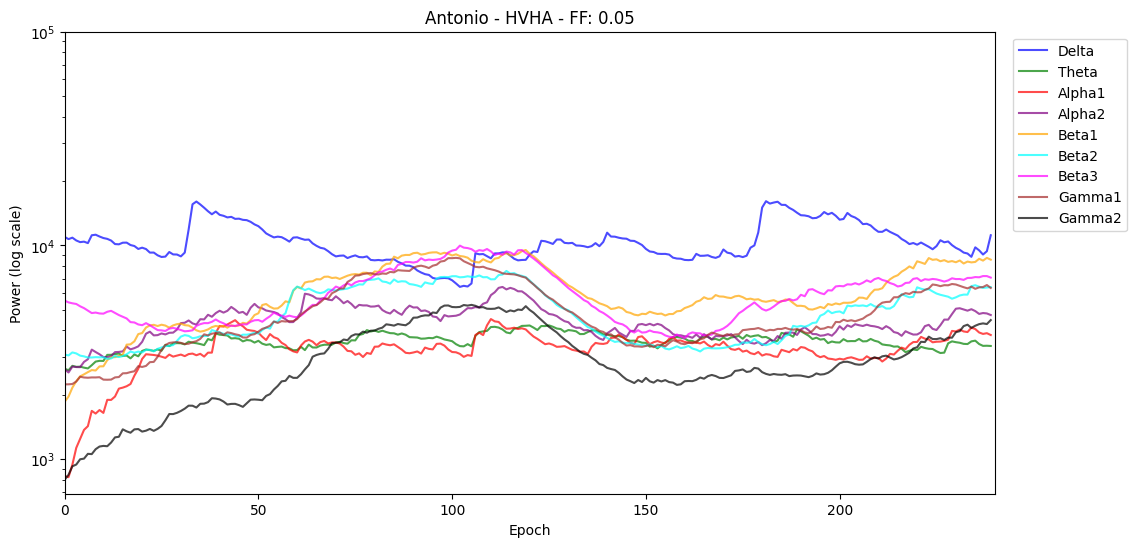

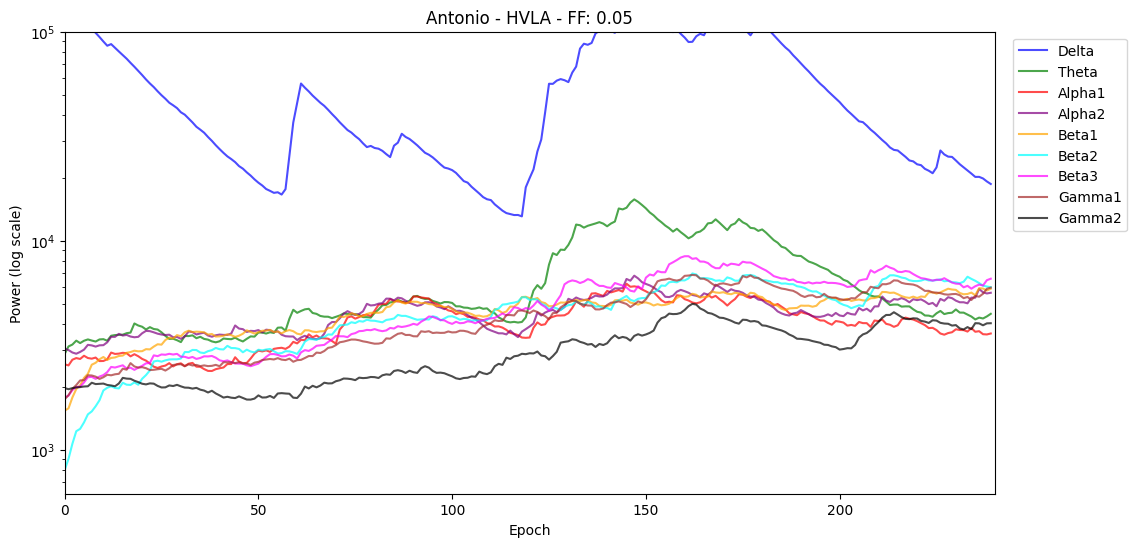

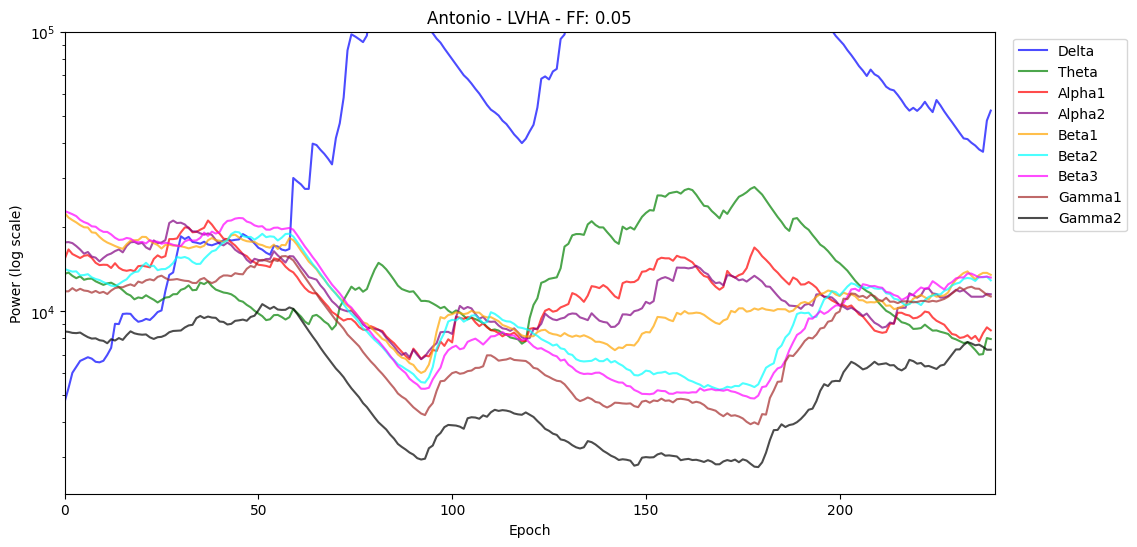

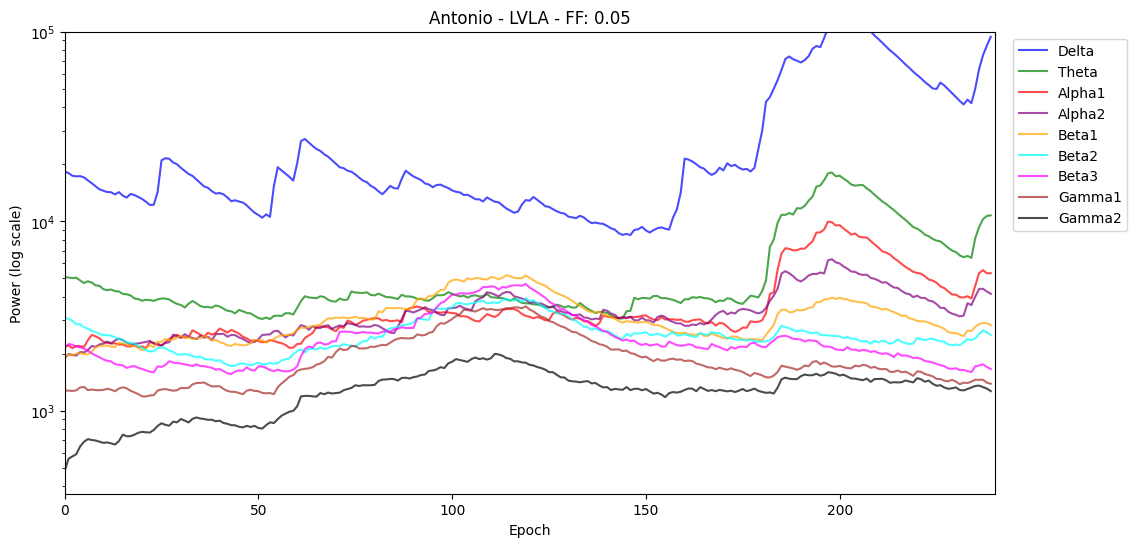

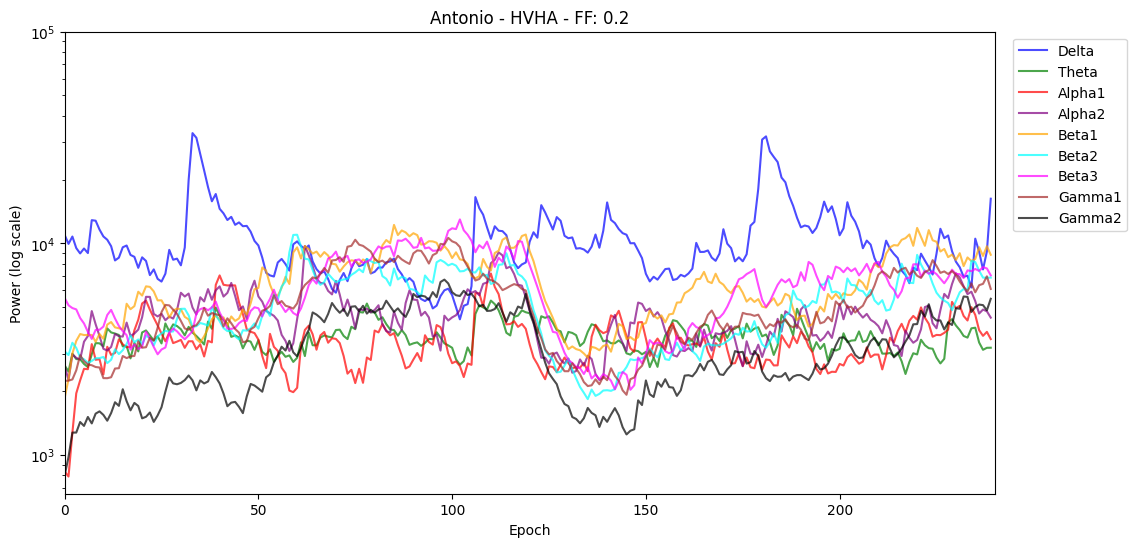

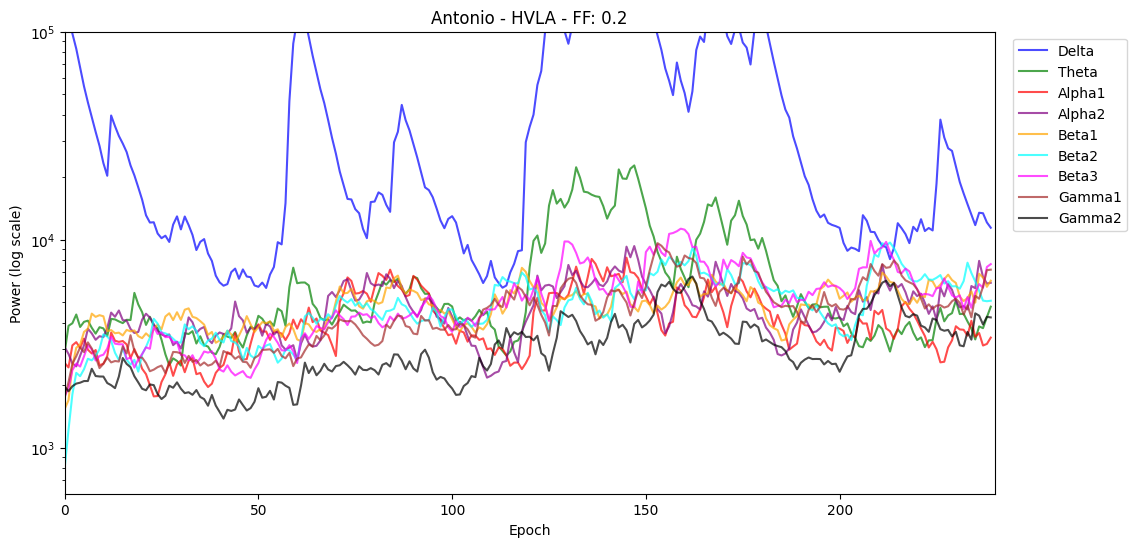

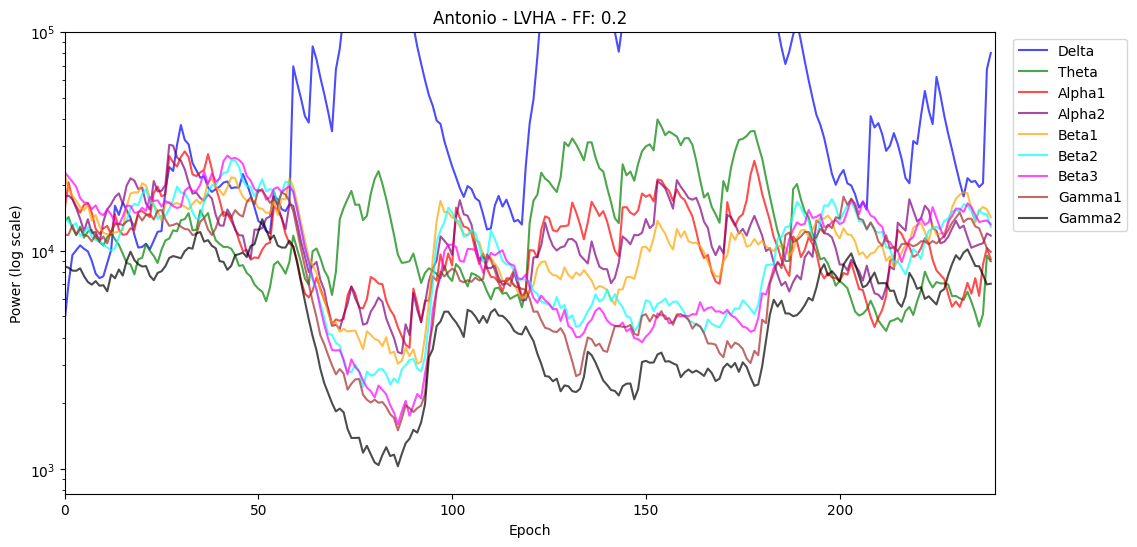

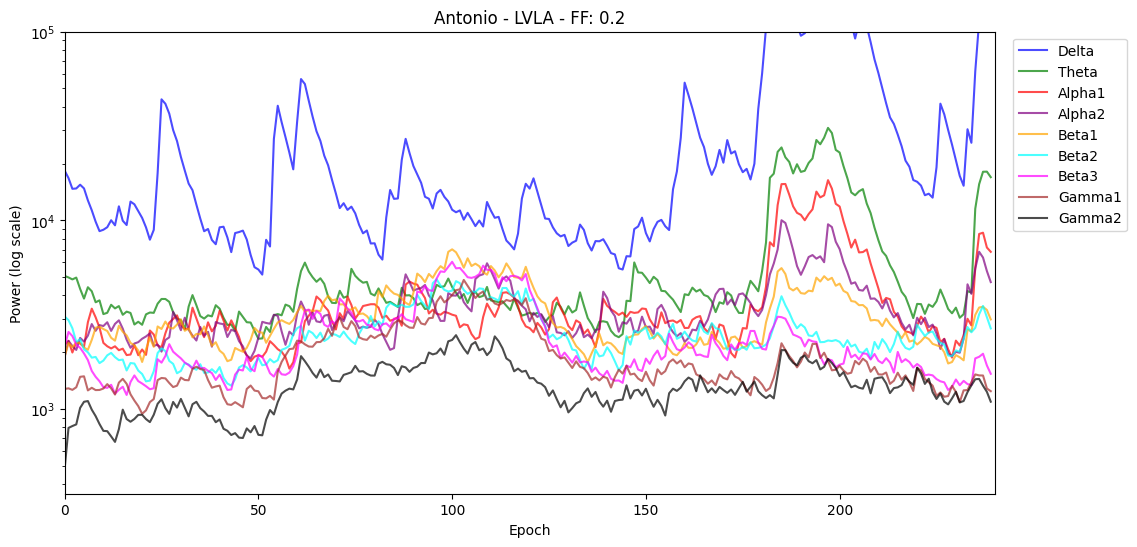

In [250]:
def plot_antonio_data(df_ff, FF):
    """
    Plots Antonio's power feature vectors for each emotional state (HVHA, HVLA, LVHA, LVLA).

    Parameters:
        df_ff (pd.DataFrame): DataFrame with Forgetting Factor applied.
        FF (float): Forgetting Factor value.

    Returns:
        None
    """


    antonio_df = df_ff[(df_ff["Participant"] == "Antonio") & (df_ff["Channel"] == 0)]
    conditions = ["HVHA", "HVLA", "LVHA", "LVLA"]
    freq_bands = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Beta3", "Gamma1", "Gamma2"]

    # Assign consistent colors to frequency bands
    colors = {
        "Delta": "blue",
        "Theta": "green",
        "Alpha1": "red",
        "Alpha2": "purple",
        "Beta1": "orange",
        "Beta2": "cyan",
        "Beta3": "magenta",
        "Gamma1": "brown",
        "Gamma2": "black"
    }

    for condition in conditions:
        plt.figure(figsize=(12, 6))
        plt.title(f"Antonio - {condition} - FF: {FF}")
        plt.xlabel("Epoch")
        plt.ylabel("Power (log scale)")
        
        # Filter data by condition
        condition_df = antonio_df[antonio_df["Condition"] == condition]

        # Sort by epoch
        condition_df = condition_df.sort_values(by="Epoch")

        for band in freq_bands:
            plt.plot(condition_df["Epoch"], condition_df[band], label=band, color=colors[band], alpha=0.7)
        
        plt.yscale("log")
        plt.ylim([0,1e5])
        plt.xlim([0,240])
        plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
        plt.show()

# Plot for FF = 0.05
plot_antonio_data(df_vec_ff_005, 0.05)

# Plot for FF = 0.15
#plot_antonio_data(df_vec_ff_015, 0.15)

# Plot for FF = 0.18
#plot_antonio_data(df_vec_ff_020, 0.18)

# Plot for FF = 0.25
plot_antonio_data(df_vec_ff_020, 0.20)

# Plot for FF = 1.0
#plot_antonio_data(df_vec_ff_1, 1.0)

In [ ]:

# Define function to assign arousal and valence labels outside the main function
def assign_labels(condition):
    """
    Assigns binary labels based on the condition.
    
    Parameters:
        condition (str): One of HVHA, HVLA, LVHA, LVLA.
        
    Returns:
        tuple: (Arousal label, Valence label)
    """
    high_arousal = ["HVHA", "LVHA"]
    low_arousal = ["HVLA", "LVLA"]
    high_valence = ["HVHA", "HVLA"]
    low_valence = ["LVHA", "LVLA"]

    arousal_label = 1 if condition in high_arousal else 0  # High = 1, Low = 0
    valence_label = 1 if condition in high_valence else 0  # High = 1, Low = 0

    return arousal_label, valence_label

def run_svm_classification_improved(df_vec_ff):
    """
    Runs SVM classification for each participant independently (using all features)
    for both arousal and valence tasks with an expanded parameter grid and 
    time-based split. Returns SVM results and a summary DataFrame.
    
    Parameters:
        df_vec_ff (pd.DataFrame): DataFrame with smoothed feature vectors and labels.
        
    Returns:
        tuple: (results_arousal, results_valence, summary_df)
    """
    # Use all frequency band features
    features = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Beta3", "Gamma1", "Gamma2"]
    
    results_arousal = {}
    results_valence = {}
    
    # Get unique participants
    unique_participants = df_vec_ff["Participant"].unique()
    
    # Expanded grid search parameters
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 0.1, 0.01, 0.001, 0.0001], 
        'kernel': ['rbf']  
    }
    
    for participant in unique_participants:
        print(f"\n{'='*50}")
        print(f"Processing Participant: {participant}")
        print(f"{'='*50}")
        
        # For this analysis, we use data from the right mastoid
        df_part = df_vec_ff[(df_vec_ff["Participant"] == participant) & 
                           (df_vec_ff["Channel"] == 0)]
        
        # Print class distribution to check balance
        print(f"Total samples: {len(df_part)}")
        print("Arousal class distribution:", df_part['Arousal_Label'].value_counts().to_dict())
        print("Valence class distribution:", df_part['Valence_Label'].value_counts().to_dict())
        
        # Sort by epoch (time-based split)
        df_part_sorted = df_part.sort_values(by="Epoch")
        X = df_part_sorted[features].values
        y_arousal = df_part_sorted["Arousal_Label"].values
        y_valence = df_part_sorted["Valence_Label"].values
        
        # Use a time-based split (first 70% for training, last 30% for testing)
        split_idx = int(len(X) * 0.7)
        
        # # Arousal Classification  *********
        print("\nAROUSAL CLASSIFICATION") 
        print("-" * 30)
        X_train_a, X_test_a = X[:split_idx], X[split_idx:]
        y_train_a, y_test_a = y_arousal[:split_idx], y_arousal[split_idx:]
        
        scaler_a = StandardScaler()
        X_train_a = scaler_a.fit_transform(X_train_a)
        X_test_a = scaler_a.transform(X_test_a)
        
        grid_a = GridSearchCV(
            SVC(class_weight='balanced', random_state=42),
            param_grid,
            cv=StratifiedKFold(6),
            scoring='f1_weighted',
            verbose=0
        )
        grid_a.fit(X_train_a, y_train_a)
        best_svm_a = grid_a.best_estimator_
        print("Best parameters (Arousal):", grid_a.best_params_)
        
        cv_scores_a = cross_val_score(best_svm_a, X_train_a, y_train_a,
                                      cv=StratifiedKFold(6), scoring='accuracy')
        print(f"Cross-validation accuracy: {cv_scores_a.mean():.4f} ± {cv_scores_a.std():.4f}")
        
        y_pred_a = best_svm_a.predict(X_test_a)
        results_arousal[participant] = {
            'accuracy': accuracy_score(y_test_a, y_pred_a),
            'classification_report': classification_report(y_test_a, y_pred_a, output_dict=True),
            'best_params': grid_a.best_params_,
            'cv_scores': {'mean': cv_scores_a.mean(), 'std': cv_scores_a.std()}
        }
        print("Test accuracy (Arousal):", accuracy_score(y_test_a, y_pred_a))
        print(classification_report(y_test_a, y_pred_a))
        
        # # Valence Classification *********
        print("\nVALENCE CLASSIFICATION")
        print("-" * 30)
        X_train_v, X_test_v = X[:split_idx], X[split_idx:]
        y_train_v, y_test_v = y_valence[:split_idx], y_valence[split_idx:]
        
        scaler_v = StandardScaler()
        X_train_v = scaler_v.fit_transform(X_train_v)
        X_test_v = scaler_v.transform(X_test_v)
        
        grid_v = GridSearchCV(
            SVC(class_weight='balanced', random_state=42),
            param_grid,
            cv=StratifiedKFold(6),
            scoring='f1_weighted',
            verbose=0
        )
        grid_v.fit(X_train_v, y_train_v)
        best_svm_v = grid_v.best_estimator_
        print("Best parameters (Valence):", grid_v.best_params_)
        
        cv_scores_v = cross_val_score(best_svm_v, X_train_v, y_train_v,
                                      cv=StratifiedKFold(6), scoring='accuracy')
        print(f"Cross-validation accuracy: {cv_scores_v.mean():.4f} ± {cv_scores_v.std():.4f}")
        
        y_pred_v = best_svm_v.predict(X_test_v)
        results_valence[participant] = {
            'accuracy': accuracy_score(y_test_v, y_pred_v),
            'classification_report': classification_report(y_test_v, y_pred_v, output_dict=True),
            'best_params': grid_v.best_params_,
            'cv_scores': {'mean': cv_scores_v.mean(), 'std': cv_scores_v.std()}
        }
        print("Test accuracy (Valence):", accuracy_score(y_test_v, y_pred_v))
        print(classification_report(y_test_v, y_pred_v))
    
    # Create a summary table for a quick overview
    summary_data = []
    for p in unique_participants:
        arousal_metrics = results_arousal[p]['classification_report']['weighted avg']
        valence_metrics = results_valence[p]['classification_report']['weighted avg']
        summary_data.append({
            'Participant': p,
            'Arousal Accuracy': results_arousal[p]['accuracy'],
            'Arousal F1': arousal_metrics['f1-score'],
            'Arousal Precision': arousal_metrics['precision'],
            'Arousal Recall': arousal_metrics['recall'],
            'Valence Accuracy': results_valence[p]['accuracy'],
            'Valence F1': valence_metrics['f1-score'],
            'Valence Precision': valence_metrics['precision'],
            'Valence Recall': valence_metrics['recall']
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nSummary Results Table:")
    display(summary_df)
    
    return results_arousal, results_valence, summary_df

# Make sure you have the correct DataFrame variable name (last 3 digits correspond to which FF applied) ***
if 'Arousal_Label' not in df_vec_ff_005.columns:
    # Add the labels to the DataFrame
    df_vec_ff_005[['Arousal_Label', 'Valence_Label']] = df_vec_ff_005['Condition'].apply(
        lambda x: pd.Series(assign_labels(x))
    )

# Run the SVM classification and the summary DataFrame
results_arousal, results_valence, summary_df = run_svm_classification_improved(df_vec_ff_005)


Processing Participant: Ale
Total samples: 954
Arousal class distribution: {0: 480, 1: 474}
Valence class distribution: {0: 480, 1: 474}

AROUSAL CLASSIFICATION
------------------------------
Best parameters (Arousal): {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Cross-validation accuracy: 0.8935 ± 0.0924
Test accuracy (Arousal): 0.8466898954703833
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       145
           1       1.00      0.69      0.82       142

    accuracy                           0.85       287
   macro avg       0.88      0.85      0.84       287
weighted avg       0.88      0.85      0.84       287


VALENCE CLASSIFICATION
------------------------------
Best parameters (Valence): {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-validation accuracy: 0.9385 ± 0.0599
Test accuracy (Valence): 0.7003484320557491
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       145
  

,Participant,Arousal Accuracy,Arousal F1,Arousal Precision,Arousal Recall,Valence Accuracy,Valence F1,Valence Precision,Valence Recall
0,Ale,0.846690,0.842735,0.882381,0.846690,0.700348,0.700356,0.700431,0.700348
1,Ana,0.937500,0.937255,0.944444,0.937500,0.506944,0.491622,0.507896,0.506944
2,Antonio,0.895833,0.894839,0.911387,0.895833,0.951389,0.951274,0.955696,0.951389
3,Jenny,0.621528,0.618654,0.625305,0.621528,0.840278,0.836807,0.871917,0.840278
4,Luisa,0.545139,0.544210,0.545510,0.545139,0.833333,0.833261,0.833913,0.833333


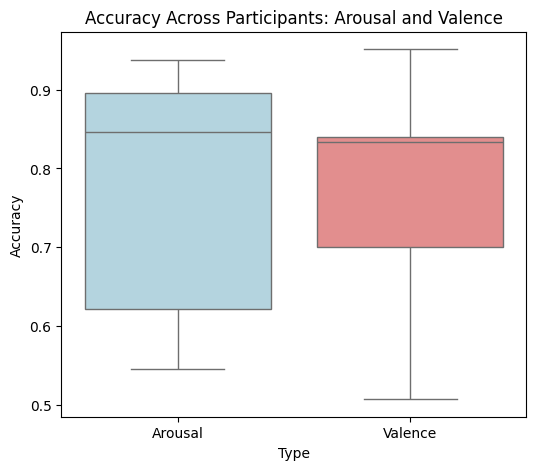

In [ ]:
# Reshape the summary_df into a long format for the boxplot
data_list = []
for _, row in summary_df.iterrows():
    data_list.append({"Participant": row["Participant"], "Type": "Arousal", "Accuracy": row["Arousal Accuracy"]})
    data_list.append({"Participant": row["Participant"], "Type": "Valence", "Accuracy": row["Valence Accuracy"]})
    
df_long = pd.DataFrame(data_list)

# Plot results using a box-plot
plt.figure(figsize=(6,5))
sns.boxplot(
    x="Type", 
    y="Accuracy",
    hue="Type",  
    data=df_long, 
    palette={"Arousal": "lightblue", "Valence": "lightcoral"}, 
    legend=False 
)
#plt.axhline(y=0.5, color='red', linestyle='--')
plt.title("Accuracy Across Participants: Arousal and Valence")
plt.ylabel("Accuracy")
plt.show()